# Bandit Sequence Design

This notebook is for the second round design. The current design only makes use of the first round results. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading First Round Results (new data)

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)

Path = '../../data/firstRound_4h+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,RBS,RBS6,AVERAGE,STD,variable,label,Group
0,TTTAAGAAGGAGATATACAT,AGGAGA,2.196595,0.811007,Rep1,2.648575,First round result
1,CTTAAGAAGGAGATATACAT,AGGAGA,1.288441,0.429194,Rep1,1.399539,First round result
2,GTTAAGAAGGAGATATACAT,AGGAGA,0.347877,0.118192,Rep1,0.317903,First round result
3,ATTAAGAAGGAGATATACAT,AGGAGA,1.143829,0.450811,Rep1,1.531393,First round result
4,TCTAAGAAGGAGATATACAT,AGGAGA,1.248348,0.644664,Rep1,1.386412,First round result


(266, 7)

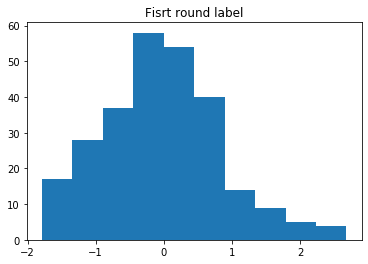

In [3]:
# extract first round result
df_FRR = df[df['Group'] == 'First round result']
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

In [4]:
data = np.asarray(df_FRR[['RBS', 'label']])
data.shape

(266, 2)

In [5]:
data6 = np.asarray(df_FRR[['RBS6', 'label']])
data6.shape

(266, 2)

Text(0.5, 1.0, 'Normalised GFPOD Histogram')

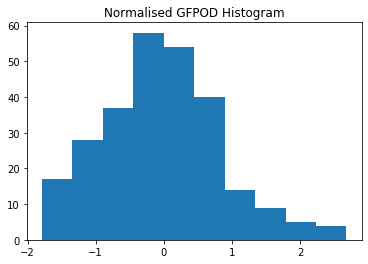

In [6]:
plt.hist(data[:,1])
plt.title('Normalised GFPOD Histogram')

## Construct feature spaces

We fix the part other the designing 6-base RBS, the 20-based RBS would be: 'TTTAAGA' + 6-base design + 'TATACAT'. The 6-base design has totally 4^6 = 4096 combinations. 

In [7]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combos_6.append(''.join(combo))
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [8]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

## Setting

Since the sequences in provided data have the pattern that the core area is different from each other, and other areas are similar. So the kernel for Gaussain Process we are using is the sum of kernels, for core areas we use spectrum kernel with string as input directly, and for other areas we use onehot encoding and dot product kernel for simplicity. 

In [9]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively
kernel = [spectrum_kernel, sum_onehot_spectrum_kernel_pw]
string_kernel_flag = True

## Recommendations with GPUCB

[2473 1702 2662 2671 3220 1321 1289 2057  166 2458 2121 3266  898 2242
 1801 2729 2715 2713  329 3109  614 3593   38 2459  618 2730  623 2457
 1638 1642 1647 1705 2665 1178 1690  170 2086 3114  169 1706  146 1737
 3849 3111  617 3108 1691 1179 1318 1177 1689 1641  148 3113 3226 3081
  777 3227 3225 1730 2825 3110  154  155  153]


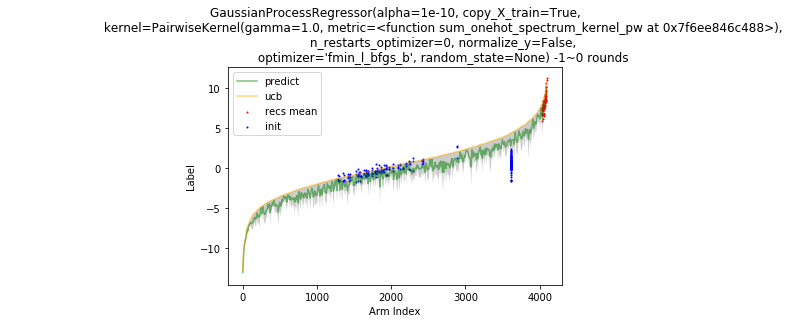

In [10]:
num_rounds = 1 
num_exper = 1
num_rec = 65

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

### Convert to RBS seq

In [11]:
bandit20_recs = todesign_data[np.asarray(rec_arms[-60:]),0]

In [12]:
bandit20_recs

array(['TTTAAGAGGACCGTATACAT', 'TTTAAGAGGAACGTATACAT',
       'TTTAAGACAAACGTATACAT', 'TTTAAGAAACCGCTATACAT',
       'TTTAAGACGCGCCTATACAT', 'TTTAAGACAGACGTATACAT',
       'TTTAAGATATAACTATACAT', 'TTTAAGAATCAACTATACAT',
       'TTTAAGACATAACTATACAT', 'TTTAAGAGTAACGTATACAT',
       'TTTAAGACCCCCGTATACAT', 'TTTAAGACCCGCTTATACAT',
       'TTTAAGACCCGCGTATACAT', 'TTTAAGAAGGACGTATACAT',
       'TTTAAGATAACGGTATACAT', 'TTTAAGAACGCGCTATACAT',
       'TTTAAGATCAACGTATACAT', 'TTTAAGAAAACGCTATACAT',
       'TTTAAGACGCGCTTATACAT', 'TTTAAGAACGCCCTATACAT',
       'TTTAAGACCCCCCTATACAT', 'TTTAAGAACGCTTTATACAT',
       'TTTAAGACGCGCGTATACAT', 'TTTAAGAGCGCGCTATACAT',
       'TTTAAGAGCGCCCTATACAT', 'TTTAAGAGCGCTTTATACAT',
       'TTTAAGAGCCCCGTATACAT', 'TTTAAGACCGCCGTATACAT',
       'TTTAAGAGACGCCTATACAT', 'TTTAAGAGCCGCCTATACAT',
       'TTTAAGAAACCCCTATACAT', 'TTTAAGACAACGCTATACAT',
       'TTTAAGATAACCCTATACAT', 'TTTAAGAAACCCGTATACAT',
       'TTTAAGAGCCCCCTATACAT', 'TTTAAGAAACGACTATACAT',
       'TT

### Detect Repeated Recs

In [13]:
first_round_seq = pd.read_csv('../../data/first_round_seq.csv')

In [14]:
first_round_seq

,RBS,Group,RBS6
0,TTTAAGAAGGAGATATACAT,bps,AGGAGA
1,CTTAAGAAGGAGATATACAT,bps,AGGAGA
2,GTTAAGAAGGAGATATACAT,bps,AGGAGA
3,ATTAAGAAGGAGATATACAT,bps,AGGAGA
4,TCTAAGAAGGAGATATACAT,bps,AGGAGA
5,TGTAAGAAGGAGATATACAT,bps,AGGAGA
6,TATAAGAAGGAGATATACAT,bps,AGGAGA
7,TTCAAGAAGGAGATATACAT,bps,AGGAGA
8,TTGAAGAAGGAGATATACAT,bps,AGGAGA
9,TTAAAGAAGGAGATATACAT,bps,AGGAGA


In [15]:
def common_member(a, b): 
    assert len(a[0]) == len(b[0]) 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [16]:
bandit_drop = common_member(np.asarray(first_round_seq['RBS']), bandit20_recs)
bandit_drop

{'TTTAAGACCCCCCTATACAT', 'TTTAAGACCCCCGTATACAT', 'TTTAAGAGCCCCCTATACAT'}

In [17]:
if type(bandit_drop) is set:
    bandit20_recs = list(bandit20_recs)
    for i in bandit_drop:
        print(i)
        bandit20_recs.remove(i)
        
    bandit20_recs.extend(todesign_data[np.asarray(rec_arms[60: 60 + len(bandit_drop)]),0])
    assert common_member(np.asarray(first_round_seq['RBS']), bandit20_recs) == 'no common elements'
    assert len(bandit20_recs) == 60

TTTAAGAGCCCCCTATACAT
TTTAAGACCCCCGTATACAT
TTTAAGACCCCCCTATACAT


### Write into csv file

In [18]:
recs = pd.DataFrame(bandit20_recs, columns = ['bandit'])
recs.index += 1
recs.to_csv('../../data/bandit_recs_second_round.csv')

#### Sanity test of idx consistency

In [19]:
label_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
label_dict = {'0': 'A',
              '1': 'C',
              '2': 'G',
              '3': 'T'}

rbs_seqs = []

for seq in label_seqs:
    rbs_seq = []
    for i in range(int(len(seq))):
        start = i 
        end = start + 1
        s = seq[start:end]
        rbs_seq.append(label_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)

for i in range(len(rec_arms)):
    assert rbs_seqs[i] == todesign_data[rec_arms[i], 0] 
    
print('Recommned index is consistent of the todesign_data index.')

Recommned index is consistent of the todesign_data index.


### Plot kernel matrix 

In [20]:
# use 6-base seuqence for kernel matrix
all_data = np.concatenate((data6, todesign6_data)) # both the observed and todeisign data
all_env = Rewards_env(all_data, embedding)
if len(kernel) == 1:
    kernel_matrix = kernel[0].__call__(all_env.embedded)
else: # string kernels
    kernel_matrix = kernel[0](all_data[:,0])

[[-0.03296687 -0.0397129  -0.04067845 ... -0.03922338 -0.03946872
  -0.03245092]
 [-0.03296687 -0.0397129  -0.04067845 ... -0.03922338 -0.03946872
  -0.03245092]
 [-0.03296687 -0.0397129  -0.04067845 ... -0.03922338 -0.03946872
  -0.03245092]
 ...
 [-0.01861745 -0.02242714 -0.02297242 ... -0.02215069  0.3530995
   0.91845129]
 [-0.01860305 -0.0224098  -0.02295466 ...  0.35500166 -0.02227201
   0.91774115]
 [-0.01496881 -0.01803188 -0.01847029 ... -0.01780961 -0.01792101
   0.98951628]]
[[-0.03296687 -0.03296687 -0.03296687 ... -0.01861745 -0.01860305
  -0.01496881]
 [-0.0397129  -0.0397129  -0.0397129  ... -0.02242714 -0.0224098
  -0.01803188]
 [-0.04067845 -0.04067845 -0.04067845 ... -0.02297242 -0.02295466
  -0.01847029]
 ...
 [-0.03922338 -0.03922338 -0.03922338 ... -0.02215069  0.35500166
  -0.01780961]
 [-0.03946872 -0.03946872 -0.03946872 ...  0.3530995  -0.02227201
  -0.01792101]
 [-0.03245092 -0.03245092 -0.03245092 ...  0.91845129  0.91774115
   0.98951628]]


In [21]:
kernel_matrix

array([[ 1.        ,  1.        ,  1.        , ..., -0.04738481,
        -0.04733603, -0.03433312],
       [ 1.        ,  1.        ,  1.        , ..., -0.04738481,
        -0.04733603, -0.03433312],
       [ 1.        ,  1.        ,  1.        , ..., -0.04738481,
        -0.04733603, -0.03433312],
       ...,
       [-0.04738481, -0.04738481, -0.04738481, ...,  1.        ,
         0.8584259 ,  0.9280367 ],
       [-0.04733603, -0.04733603, -0.04733603, ...,  0.8584259 ,
         1.        ,  0.92732466],
       [-0.03433312, -0.03433312, -0.03433312, ...,  0.9280367 ,
         0.92732466,  1.        ]])

Text(0.5, 1.0, 'spectrum kernel')

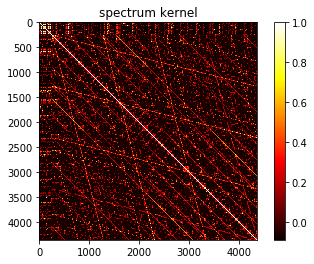

In [22]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('spectrum kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

In [23]:
new_kernel_matrix = kernel_matrix[113:, 113:] # only the todesign feature spaces

## Similarity Test

We expect that for similar arms, the predictor gives similar predictions. The above plot cannot show the similarity relationship between arm. So we design several experiments to show the similarity between arms and corresponding predictions. 

#### The goals are two folds: 
1. Understand how well the predictor works by showing the predictions for arms with similarity information. A good predictor should be able to predict similar labels for similar arms.
2. Explore the similarities of the recommended arms. If the top arms are similar to each other, then they are all from the same cluster, which is not a good way to suggest 60 arms. If they form 5-6 clusters, then this means you will see blocks in the kernel matrix, which is good.

#### The ways to explore similarities:  

A. sort the arm indexes in terms of the 
- A1) predictions (mu) 
- A2) the UCB (mu + sigma)
- A3) the confidence width (sigma)  respectively, then sort the kernel matrix in the same order.

Then we can analyze for similar scores (A1), whether the arms have high similarities. Furthermore, we can analyze the similarities for recommended arms (A2 with top 60). 

B. Using the distance (l2 norm) between every single point to the average one as x-axis, the difference between labels of every point to the averaged label as the y-axis. Then sorted the arm based on the distance of arms, then we expect the higher than the distance of arms, the higher the difference between labels.

C. Using PCA to project the similarity matrix into one/two dimensions. Then use the weight as the x-axis and the corresponding label as the y-axis. Sorted based on the x-axis. Similarly, we expected the neighboring arms have similar labels.

D. Calculate the determinant for the kernel matrix, which reflects the volume of arms. The lower the volume, the higher the similarities. 

### A. sorting by labels

#### A1. sorting by mu

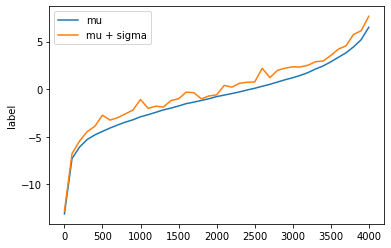

In [24]:
sorted_idx = np.asarray(sorted(range(len(agent.mu)), key=lambda k: (agent.mu)[k]))
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

Text(0.5, 1.0, 'spectrum sorted kernel')

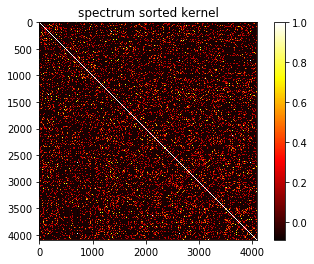

In [25]:
sorted_new_kernel_matrix = new_kernel_matrix[sorted_idx, :][:, sorted_idx]
plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('spectrum sorted kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

Text(0.5, 1.0, 'spectrum sorted kernel Top 60')

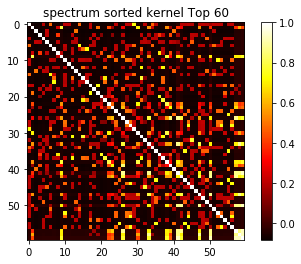

In [26]:
plt.imshow(sorted_new_kernel_matrix[-60:, -60:], cmap = 'hot')
plt.colorbar()
plt.title('spectrum sorted kernel Top 60')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

#### A2. sorting by ucb (mu + sigma)

In [27]:
sorted_idx = np.asarray(sorted(range(len(agent.mu + agent.sigma)), key=lambda k: (agent.mu + agent.sigma)[k]))
sorted_new_kernel_matrix = new_kernel_matrix[sorted_idx, :][:, sorted_idx]

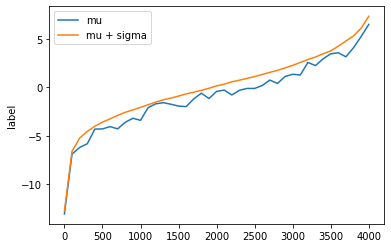

In [28]:
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

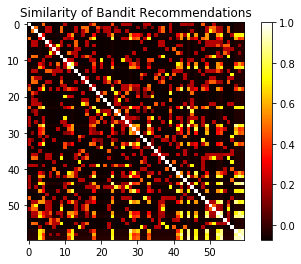

In [29]:
#plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.imshow(sorted_new_kernel_matrix[-60:,-60:], cmap = 'hot')
plt.colorbar()
plt.title('Similarity of Bandit Recommendations')
plt.savefig('../../plots/similarity_first_round_recommendation.pdf')

### B. Soring by distance to center one

In [30]:
distances = []
center = np.mean(kernel_matrix, axis = 0)
for i, row in enumerate(kernel_matrix):
    distance = np.linalg.norm(row - center) ** 2/ len(row)
    distances.append(distance)

In [31]:
sorted_idx = np.asarray(sorted(range(len(distances)), key=lambda k: (distances)[k]))

sorted_distances = np.asarray(distances)[np.asarray(sorted_idx)]

labels = list(data[:, 1])+ list(agent.mu)
sorted_labels = np.asarray(labels)[np.asarray(sorted_idx)]

Text(0, 0.5, '|labels - mean|')

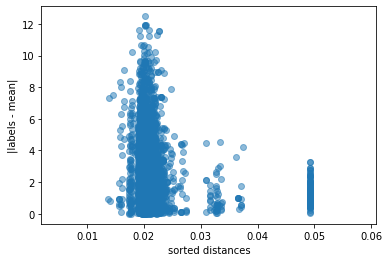

In [32]:
plt.scatter(sorted_distances, abs(sorted_labels - np.mean(labels)), alpha = 0.5)
plt.xlabel('sorted distances')
plt.ylabel('|labels - mean|')

#### A3. sorting by PCA weights

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
embedded = pca.fit_transform(kernel_matrix)
embedded.shape

(4362, 1)

Text(0.5, 1.0, 'Sort by PCA')

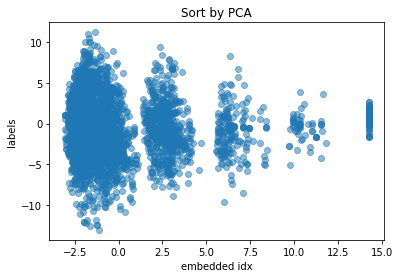

In [34]:
plt.scatter(embedded, labels, alpha = 0.5)
plt.xlabel('embedded idx')
plt.ylabel('labels')
plt.title('Sort by PCA')

#### A.4 Determinant

In [35]:
np.linalg.det(kernel_matrix[-60:, -60:])

1.6365823977666955e-37

### Save into file

In [36]:
import pickle

with open('second_round_rec.pickle', 'wb') as handle:
    pickle.dump(agent, handle, protocol=pickle.HIGHEST_PROTOCOL)